<a href="https://colab.research.google.com/github/adrian-alejandro/AprendizajeProfundo/blob/master/entregables/Aprendizaje_Profundo_Pr%C3%A1ctico_Parte_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizaje Profundo - Práctico (Parte II)

Equipo: Mariana Pereyra - Adrián Zelaya

Link al [repo de GitHub](https://github.com/adrian-alejandro/AprendizajeProfundo/tree/master/entregables).
____

Algunas consideraciones a tener en cuenta para estructurar el trabajo:

1. Hacer un preprocesamiento de los datos (¿Cómo vamos a representar los datos de entrada y las categorías?).
2. Tener un manejador del dataset (alguna clase o función que nos divida los datos en batches).
3. Crear una clase para el modelo que se pueda instanciar con diferentes hiperparámetros
4. Hacer logs de entrenamiento (reportar tiempo transcurrido, iteraciones/s, loss, accuracy, etc.). Usar MLFlow.
5. Hacer un gráfico de la función de loss a lo largo de las epochs. MLFlow también puede generar la gráfica.
6. Reportar performance en el conjunto de test con el mejor modelo entrenado. La métrica para reportar será balanced accuracy.

## Objetivo

En este práctico implementaremos una red convolucional (CNN) que asigne una categoría dado un título.



### Descarga de datos 




Definimos el entorno de trabajo: local o Google Colab. En el caso del último, procedemos a montarlo.

In [1]:
try:
    from google.colab import drive 
    drive.mount('/content/drive')
    DATA_PATH = "/content/drive/MyDrive/Diplomatura/Aprendizaje Profundo"
    MLFLOW_PATH = "/content/mlruns"
    IMAGES_PATH = "/content/images"
except:
    DATA_PATH = "data"
    MLFLOW_PATH = "mlruns"
    IMAGES_PATH = "images"
    
MLFLOW_PATH_ZIP =  MLFLOW_PATH + ".zip"

Descargamos los datos localmente usando los siguientes comandos:

```
!curl -L https://cs.famaf.unc.edu.ar/\~ccardellino/resources/diplodatos/meli-challenge-2019.tar.bz2 -o ./data/meli-challenge-2019.tar.bz2
!tar jxvf ./data/meli-challenge-2019.tar.bz2 -C ./data/
```

Luego los dividimos en train y test utilizando la siguiente [notebook](https://github.com/DiploDatos/AprendizajeProfundo/blob/master/experiment/preprocess_meli_data.ipynb).

Adicionalmente, descargamos el embedding preentrenado de Glove:

```
!curl -L https://cs.famaf.unc.edu.ar/\~ccardellino/resources/diplodatos/glove.6B.50d.txt.gz -o glove.6B.50d.txt.gz
```

Finalmente subimos estos archivos a una carpeta de drive para utilizarlos desde Google Colab.

### Librerías

Instalamos e importamos las librerías necesarias para nuestro análisis

In [2]:
!pip install gensim --upgrade 
!pip install mlflow 

  Using cached importlib_metadata-4.13.0-py3-none-any.whl (23 kB)
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 5.1.0
    Not uninstalling importlib-metadata at /app/lib/python3.10/site-packages, outside environment /home/adrian/PycharmProjects/AprendizajeProfundo/venv
    Can't uninstall 'importlib-metadata'. No files were found to uninstall.


In [23]:
import os
import csv
import functools
import json
import gzip
import bz2
import tempfile
from tqdm.notebook import tqdm, trange
import mlflow
import numpy as np
import pandas as pd
from IPython.display import Image
from IPython.core.display import HTML

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from gensim import corpora
from gensim.parsing import preprocessing
from gensim.models import KeyedVectors
from sklearn.metrics import balanced_accuracy_score

In [4]:
# Check if we have a GPU available
use_cuda = torch.cuda.is_available()
print(use_cuda)
device = torch.device('cuda') if use_cuda else torch.device('cpu')

False


Actualizamos los paths de los datasets:

In [5]:
path_meli_train = os.path.join(DATA_PATH, "meli-challenge-2019", "spanish.train.jsonl.gz")
path_meli_validation = os.path.join(DATA_PATH, "meli-challenge-2019", "spanish.validation.jsonl.gz")
path_meli_test = os.path.join(DATA_PATH, "meli-challenge-2019", "spanish.test.jsonl.gz")
path_embedding = os.path.join(DATA_PATH, "SBW-vectors-300-min5.txt.bz2")

## Dataset

Nos basaremos en el dataset del MeLi Data Challenge 2019 para trabajar en el problema de clasificación de texto de este práctico.

El dataset contiene información acerca de los títulos de publicaciones, categorías de las mismas, información de idioma y confiabilidad de la anotación. Cuenta con anotaciones de títulos para 632 categorías distintas.

El dataset también cuenta con una partición de test que está compuesta de 636,680 de ejemplos con las mismas categorías (aunque no necesariamente la misma distribución).

También hay datos en idioma portugués, aunque para este práctico nos centraremos solamente en el idioma español.

Para trabajar con el conjuntos de datos en PyTorch se podría utilizar la clase  IterableDataset. Esta elección se debe a que esta clase permite trabajar más eficientemente con un conjunto de datos grade, como es el caso del MeLi Challenge. Pero por cuestiones de simplicidad usaremos Dataset.

In [6]:
class MeLiChallengeDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
    
    def __len__(self):
        return self.dataset.shape[0]

    def __getitem__(self, item):
        if torch.is_tensor(item):
            item = item.to_list()
        
        item = {
            "data": self.dataset.loc[item, "title"],
            "target": self.dataset.loc[item, "category"]
        }
        
        if self.transform:
            item = self.transform(item)
        
        return item

Inspeccionamos la data de train usando Pandas

In [7]:
train_df = pd.concat([x for x in pd.read_json(path_meli_train, lines=True, chunksize=100000)], ignore_index=True)
train_df.head()

,language,label_quality,title,category,split,tokenized_title,data,target,n_labels,size
0,spanish,reliable,Casita Muñecas Barbies Pintadas,DOLLHOUSES,train,"[casita, muñecas, barbies, pintadas]","[50001, 2, 50000, 3]",0,632,4895280
1,spanish,unreliable,Neceser Cromado Holográfico,TOILETRY_BAGS,train,"[neceser, cromado, holográfico]","[6, 4, 5]",1,632,4895280
2,spanish,unreliable,Funda Asiento A Medida D20 Chevrolet,CAR_SEAT_COVERS,train,"[funda, asiento, medida, chevrolet]","[9, 7, 10, 8]",2,632,4895280
3,spanish,unreliable,Embrague Ford Focus One 1.8 8v Td (90cv) Desde...,AUTOMOTIVE_CLUTCH_KITS,train,"[embrague, ford, focus, one]","[11, 13, 12, 14]",3,632,4895280
4,spanish,unreliable,Bateria Panasonic Dmwbcf10 Lumix Dmc-fx60n Dmc...,CAMERA_BATTERIES,train,"[bateria, panasonic, dmwbcf, lumix, dmc, fxn, ...","[15, 19, 17, 18, 16, 1, 1, 1]",4,632,4895280


In [8]:
unreliable = train_df.label_quality.value_counts()[0]
reliable = train_df.label_quality.value_counts()[1]

print(f"Hay {reliable} registros que tienen etiquetas confiables y {unreliable} registros que no, es decir un {round(reliable/unreliable*100,2)}% tiene etiquetas confiables.")

Hay 387237 registros que tienen etiquetas confiables y 4508043 registros que no, es decir un 8.59% tiene etiquetas confiables.


Inspeccionamos la data de Validation

In [9]:
validation_df = pd.concat([x for x in pd.read_json(path_meli_validation, lines=True, chunksize=100000)], ignore_index=True)
validation_df.head()

,language,label_quality,title,category,split,tokenized_title,data,target,n_labels,size
0,spanish,unreliable,Metal Biela Dw10 Hdi 2.0,ENGINE_BEARINGS,validation,"[metal, biela, hdi]","[457, 1480, 3450]",88,632,1223820
1,spanish,unreliable,Repuestos Martillo Rotoprcutor Bosch Gshsce Po...,ELECTRIC_DEMOLITION_HAMMERS,validation,"[repuestos, martillo, rotoprcutor, bosch, gshs...","[3119, 892, 1, 767, 1, 9337]",174,632,1223820
2,spanish,unreliable,Pesca Caña Pejerrey Colony Brava 3m Fibra De V...,FISHING_RODS,validation,"[pesca, caña, pejerrey, colony, brava, fibra, ...","[700, 990, 2057, 3990, 3670, 1737, 1153, 6568]",313,632,1223820
3,spanish,unreliable,Porcelanato Abitare Be 20x120 Cm. Ceramica Por...,PORCELAIN_TILES,validation,"[porcelanato, abitare, ceramica, portinari]","[2722, 4404, 1406, 4405]",427,632,1223820
4,spanish,unreliable,Reconstruction Semi Di Lino Alfaparf Shampoo 1...,HAIR_SHAMPOOS_AND_CONDITIONERS,validation,"[reconstruction, semi, lino, alfaparf, shampoo]","[1, 3365, 7502, 10919, 849]",194,632,1223820


Inspeccionamos la data de Test

In [10]:
test_df = pd.concat([x for x in pd.read_json(path_meli_test, lines=True, chunksize=100000)], ignore_index=True)
test_df.head()

,language,label_quality,title,category,split,tokenized_title,data,target,n_labels,size
0,spanish,reliable,Mochilas Maternales Bolsos Bebe Simil Cuero Ma...,DIAPER_BAGS,test,"[mochilas, maternales, bolsos, bebe, simil, cu...","[5650, 5271, 5268, 915, 2724, 375, 37363]",318,632,63680
1,spanish,reliable,Bolso Maternal/bebe Incluye Cambiador + Correa...,DIAPER_BAGS,test,"[bolso, maternal, bebe, incluye, cambiador, co...","[502, 2742, 915, 3031, 2740, 1840, 4635]",318,632,63680
2,spanish,reliable,Mochila Maternal Land + Gancho Envio Gratis-cc,DIAPER_BAGS,test,"[mochila, maternal, land, gancho, envio, gratis]","[337, 2742, 2741, 3303, 211, 1429]",318,632,63680
3,spanish,reliable,Bolso Maternal Moderno Con Cambiador Y Correa ...,DIAPER_BAGS,test,"[bolso, maternal, moderno, cambiador, correa, ...","[502, 2742, 2983, 2740, 1840, 476, 2990]",318,632,63680
4,spanish,reliable,Bolso Maternal Moderno Con Cambiador Y Correa ...,DIAPER_BAGS,test,"[bolso, maternal, moderno, cambiador, correa, ...","[502, 2742, 2983, 2740, 1840, 4635]",318,632,63680


Concatenamos los sets de training, validation y testing:

In [11]:
df_concat = [train_df, validation_df, test_df]
dataset = pd.concat(df_concat, ignore_index=True)
dataset.head()

,language,label_quality,title,category,split,tokenized_title,data,target,n_labels,size
0,spanish,reliable,Casita Muñecas Barbies Pintadas,DOLLHOUSES,train,"[casita, muñecas, barbies, pintadas]","[50001, 2, 50000, 3]",0,632,4895280
1,spanish,unreliable,Neceser Cromado Holográfico,TOILETRY_BAGS,train,"[neceser, cromado, holográfico]","[6, 4, 5]",1,632,4895280
2,spanish,unreliable,Funda Asiento A Medida D20 Chevrolet,CAR_SEAT_COVERS,train,"[funda, asiento, medida, chevrolet]","[9, 7, 10, 8]",2,632,4895280
3,spanish,unreliable,Embrague Ford Focus One 1.8 8v Td (90cv) Desde...,AUTOMOTIVE_CLUTCH_KITS,train,"[embrague, ford, focus, one]","[11, 13, 12, 14]",3,632,4895280
4,spanish,unreliable,Bateria Panasonic Dmwbcf10 Lumix Dmc-fx60n Dmc...,CAMERA_BATTERIES,train,"[bateria, panasonic, dmwbcf, lumix, dmc, fxn, ...","[15, 19, 17, 18, 16, 1, 1, 1]",4,632,4895280


Chequeamos que las categorías en train y test sean las mismas:

In [13]:
n_categories = len(dataset.category.unique())

In [14]:
len(train_df.category.unique()) == len(test_df.category.unique()) == len(validation_df.category.unique())

True

## Preprocesamiento

Vamos a utilizar el siguiente procesador, visto en clase (notebook 4). Este se encargará de preprocesar el texto (i.e. normalizarlo) y transformará las palabras en índices de un diccionario para luego poder pasar una secuencia de palabras para buscar en la matriz de embeddings y así permitir mayor manipulación de los embeddings (en lugar de utilizar embeddings fijos).

Vamos a estar trabajando con la librería gensim previamente importada para el procesamiento del lenguaje natural.

En cuanto los pasos de preprocesamiento realizados, permiten uniformizar el texto de la mejor manera posible y contemplan lo siguiente:

* Pasar el texto a minúsculas (lower case).
* Remover tags de HTML que puedan estar embebidas en el texto.
* Remover símbolos de puntuación.
* Limpiar espacios: remover espacios múltiples y espacios en exceso al inicio o al final del texto ('title').
* Remover valores numéricos.
* Remover stopwords.

In [15]:
class RawDataProcessor:
    def __init__(self, 
                 dataset, 
                 ignore_header=True, 
                 filters=None, 
                 vocab_size=50000):
        if filters:
            self.filters = filters
        else:
            self.filters = [ #We set some filters
                lambda s: s.lower(),
                preprocessing.strip_tags,
                preprocessing.strip_punctuation,
                preprocessing.strip_multiple_whitespaces,
                preprocessing.strip_numeric,
                preprocessing.remove_stopwords,
                preprocessing.strip_short,
            ]
        # Create dictionary based on all the reviews (with corresponding preprocessing and filters)
        # The dictionary has idx as a key and word as a value
        # For example one element could be (0, 'accustomed') or (1, 'agenda')
        self.dictionary = corpora.Dictionary(
            dataset["title"].map(self._preprocess_string).tolist()
        )
        
        # Filter the dictionary and compactify it (make the indices continous)
        self.dictionary.filter_extremes(no_below=2, no_above=1, keep_n=vocab_size)
        self.dictionary.compactify()
        # Add a couple of special tokens
        self.dictionary.patch_with_special_tokens({
            "[PAD]": 0, #The padding token
            "[UNK]": 1  # The unknown token
        })
        
        self.idx_to_target = sorted(dataset["category"].unique())
        self.target_to_idx = {t: i for i, t in enumerate(self.idx_to_target)}
        

    def _preprocess_string(self, string):
        return preprocessing.preprocess_string(string, filters=self.filters)

    def _sentence_to_indices(self, sentence):
        return self.dictionary.doc2idx(sentence, unknown_word_index=1)
    
    def encode_data(self, data):
        return self._sentence_to_indices(self._preprocess_string(data))
    
    def encode_target(self, target):
        return self.target_to_idx[target]
    
    def __call__(self, item):
        #Encodeamos tanto los datos como los targets, diferenciandos los casos cuando son strings y cuando no
        if isinstance(item["data"], str): 
            data = self.encode_data(item["data"])
        else:
            data = [self.encode_data(d) for d in item["data"]]
        
        if isinstance(item["target"], str):
            target = self.encode_target(item["target"])
        else:
            target = [self.encode_target(t) for t in item["target"]]
        
        return {
            "data": data,
            "target": target
        }

## Lectura de datos

Leemos los datos del MeLiChallenge para utilizarlos en el entrenamiento y evaluación del modelo. En este caso no es necesario dividirlos entre test y training, ya que los mismos ya se encuentran divididos como tal desde los archivos de entrada.

In [16]:
preprocess = RawDataProcessor(dataset)

train_dataset = MeLiChallengeDataset(train_df, transform=preprocess)

validation_dataset = MeLiChallengeDataset(validation_df, transform=preprocess)

test_dataset = MeLiChallengeDataset(test_df, transform=preprocess)

print(f"Datasets loaded with {len(train_dataset)} training elements, {len(validation_dataset)} validation elements and {len(test_dataset)} test elements")
print(f"Sample train element:\n{train_dataset[0]}")

Datasets loaded with 4895280 training elements, 1223820 validation elements and 63680 test elements
Sample train element:
{'data': [50001, 2, 50000, 3], 'target': 188}


## Collation function

Como en este caso trabajamos con secuencias de palabras (representadas por sus índices en un vocabulario), cuando queremos buscar un batch de datos, el DataLoader de PyTorch espera que los datos del batch tengan la misma dimensión (para poder llevarlos todos a un tensor de dimensión fija). Esto lo podemos lograr mediante el parámetro de collate_fn. En particular, esta función se encarga de tomar varios elementos de un Dataset y combinarlos de manera que puedan ser devueltos como un tensor de PyTorch.

En nuestro caso, como se vio en clase, definimos un módulo PadSequences que toma un valor mínimo, opcionalmente un valor máximo y un valor de relleno (pad) y dada una lista de secuencias, devuelve un tensor con padding sobre dichas secuencias.

In [17]:
class PadSequences:
    def __init__(self, pad_value=0, max_length=None, min_length=1):
        assert max_length is None or min_length <= max_length
        self.pad_value = pad_value
        self.max_length = max_length
        self.min_length = min_length

    def __call__(self, items):
        data, target = list(zip(*[(item["data"], item["target"]) for item in items]))
        seq_lengths = [len(d) for d in data]

        if self.max_length:
            max_length = self.max_length
            seq_lengths = [min(self.max_length, l) for l in seq_lengths]
        else:
            max_length = max(self.min_length, max(seq_lengths))

        data = [d[:l] + [self.pad_value] * (max_length - l)
                for d, l in zip(data, seq_lengths)]
            
        return {
            "data": torch.LongTensor(data),
            "target": torch.LongTensor(target)
        }

## DataLoaders

Ya habiendo definido nuestros conjuntos de datos y nuestra collation_fn, podemos definir nuestros DataLoader, uno para entrenamiento y otro para evaluación.

Notar que shuffle = False para el caso del loader de evaluación, dado que no queremos mezclar los valores de evaluación cada vez que evaluamos porque al evaluar mediante mini-batchs nos puede generar inconsistencias.

A diferencia del Práctico I, en este caso aquí también definimos el número y el tamaño de los filtros que se van a utilizar en la red convolucional.

In [26]:
EPOCHS = 5
FILTERS_COUNT = 100
FILTERS_LENGTH = [2, 3, 4]
BATCH_SIZE = 512

pad_sequences = PadSequences(min_length=max(FILTERS_LENGTH))
train_loader = DataLoader(train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True,
                          collate_fn=pad_sequences, 
                          drop_last=False)
validation_loader = DataLoader(validation_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False,
                          collate_fn=pad_sequences, 
                          drop_last=False)
test_loader = DataLoader(test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False,
                         collate_fn=pad_sequences, 
                         drop_last=False)

## El modelo de clasificación

Para clasificación utilizaremos una red convolucional (CNN) basados en lo que trabajamos en clases. La misma consistía de: tres convoluciones con filtros de 2 x 100, 3 x 100 y 4 x 100; una capa fully connected y una capa de salida. Además entre las capas convolucionales definimos capas de pooling (global max pooling).


En particular, tenemos la capa de Embeddings que es rellenada con los valores de embeddings preentrenados (los de SBW en este caso).

En el caso de la capa de salida, se asume que el número de nodos se corresponde con el número de categorías posibles, en este caso 632. Se aplica como función de activación de salida una Softmax, dado que se trata de un problema de clasificación multi-clase donde las clases son mutuamente excluyentes. Los valores de salida son continuos (y van de 0 a 1), y esta función asegura que la suma de las probabilidades de todos los outputs sea 1. Luego, para determinar la clase predicha por el modelo, por fuera de la arquitectura de la red neuronal tomamos el máximo de todos los valores de salida y asignamos al nodo con el valor máximo un 1, y al resto 0 (ver sección de MLflow).

In [19]:
class MeLiChallengeClassifier(nn.Module):
    def __init__(self, 
                 pretrained_embeddings_path, 
                 dictionary,
                 vector_size,
                 freeze_embedings,
                 output_size):
        super().__init__()
        
        # Inicializamos la matriz de embeddings
        embeddings_matrix = torch.randn(len(dictionary), vector_size)
        embeddings_matrix[0] = torch.zeros(vector_size)
        
        #Trabajamos con los embeddings preentrenados
        with bz2.open(pretrained_embeddings_path, "rt") as fh:
            for line in fh:
                word, vector = line.strip().split(None, 1)
                if word in dictionary.token2id:
                    embeddings_matrix[dictionary.token2id[word]] =\
                        torch.FloatTensor([float(n) for n in vector.split()])
        
        # Los guardamos en la variable embeddings
        self.embeddings = nn.Embedding.from_pretrained(embeddings_matrix,
                                                       freeze=freeze_embedings,
                                                       padding_idx=0)
        self.convs = []
        for filter_lenght in FILTERS_LENGTH:
            self.convs.append(
                nn.Conv1d(vector_size, FILTERS_COUNT, filter_lenght) #(in_channels, out_channels, kernel_size)
            )
        self.convs = nn.ModuleList(self.convs)
        self.fc = nn.Linear(FILTERS_COUNT * len(FILTERS_LENGTH), 128)
        self.output = nn.Linear(128, output_size)
        self.vector_size = vector_size
    
    @staticmethod
    def conv_global_max_pool(x, conv):
        return F.relu(conv(x).transpose(1, 2).max(1)[0])
    
    def forward(self, x):
        x = self.embeddings(x).transpose(1, 2)  
        x = [self.conv_global_max_pool(x, conv) for conv in self.convs]
        x = torch.cat(x, dim=1)
        x = F.relu(self.fc(x))
        x = F.softmax(self.output(x))
        return x

## Experimento de MLflow

Utilizamos MLflow para hacer un mejor seguimiento del experimento y registramos la siguiente información: parámetros, métricas, error y artefactos (resultados de la predicción).

Seteamos los parámetros de antemano e hicimos las siguientes modificaciones respecto a la versión vista en clases:

* Utilizamos balanced accuracy como la métrica de evaluación, a modo de prevenir la influencia de desbalances en la distribución de clases en los datos
* Utilizamos Cross Entropy Loss dado que se trata de un problema de clasificación multi-clase
* Agregamos un validation step para asegurarnos que el modelo no esté sobreajustando (overfitting) al training dataset y que pueda generalizar con nueva data.
* Agregamos un paso previo a la evaluación de las predicciones, que toma el valor máximo de la capa de salida (output layer) y asigna 1 al nodo que tiene el valor máximo y 0 en los otros casos. De este modo nos aseguramos de que haya una sola clase como output.

In [20]:
min_valid_loss = np.inf
embedding_size = 300
output_size = n_categories

In [24]:
EXPERIMENT = f"deep_learning_CNN_experiment_{pd.datetime.now().strftime('%Y-%m-%dT%H%M%S')}"

mlflow.create_experiment(EXPERIMENT)

with mlflow.start_run():
    mlflow.log_param("model_name", "cnn")
    mlflow.log_param("freeze_embedding", True)
    mlflow.log_params({
        "filters_count": FILTERS_COUNT,
        "filters_length": FILTERS_LENGTH,
        "fc_size": 128
    })
    model = MeLiChallengeClassifier(path_embedding,
                                    preprocess.dictionary,                              
                                    embedding_size,
                                    True,
                                    output_size)
    loss = nn.CrossEntropyLoss() # Usamos Cross Entropy Loss al tratarse de un multi-class classification problem
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    best_model_state = model.state_dict()
    for epoch in trange(EPOCHS):
        # Training step
        model.train()
        running_loss = []
        for idx, batch in enumerate(tqdm(train_loader)):
            optimizer.zero_grad()
            output = model(batch["data"])
            loss_value = loss(output, batch["target"])
            loss_value.backward()
            optimizer.step()
            running_loss.append(loss_value.item())
        # Logueamos métricas
        mlflow.log_metric("train_loss", sum(running_loss) / len(running_loss), epoch)
        
        # Validation step
        model.eval()
        running_loss = []
        targets = []
        predictions = []
        for batch in tqdm(validation_loader):
            output = model(batch["data"])
            running_loss.append(
                loss(output, batch["target"]).item()
            )
            targets.extend(batch["target"].numpy())
            # Tomamos el índice del valor máximo para cada predicción
            x = np.argmax(output.squeeze().detach().numpy(), axis=1)
            predictions.extend(x)
        # Vamos guardando el modelo con menor error/pérdida
        if min_valid_loss > sum(running_loss):
            min_valid_loss = sum(running_loss)
            best_model_state = model.state_dict()
        # Logueamos métricas
        mlflow.log_metric("validation_loss", sum(running_loss) / len(running_loss), epoch)
        mlflow.log_metric("validation_balanced_accuracy", balanced_accuracy_score(targets, predictions), epoch)
        print(f"validation balanced accuracy:{balanced_accuracy_score(targets, predictions)}")
    
    with tempfile.TemporaryDirectory() as tmpdirname:
        model.load_state_dict(best_model_state) # Cargamos el modelo cuyos parámetros corresponden a la menor loss
        model.eval()
        targets = []
        predictions = []
        for batch in tqdm(test_loader):
            output = model(batch["data"])
            targets.extend(batch["target"].numpy())
            # Tomamos el índice del valor máximo para cada predicción
            x = np.argmax(output.squeeze().detach().numpy(), axis=1)
            predictions.extend(x)
        # Calculamos la métrica
        print(f"Testing balanced accuracy: {balanced_accuracy_score(targets, predictions)}")
        # Guardamos las predicciones
        pd.DataFrame({"prediction": predictions, "target": targets}).to_csv(
            f"{tmpdirname}/predictions.csv.gz", index=False
        )
        # Guardamos el modelo
        torch.save(model, f'{tmpdirname}/model.pth')
        # Logueamos artefactos
        mlflow.log_artifact(f"{tmpdirname}/predictions.csv.gz")
        mlflow.log_artifact(f"{tmpdirname}/model.pth")

/run/user/1000/app/com.jetbrains.PyCharm-Community/ipykernel_3225/4020913399.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  EXPERIMENT = f"deep_learning_CNN_experiment_{pd.datetime.now().strftime('%Y-%m-%dT%H%M%S')}"


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9562 [00:00<?, ?it/s]

/run/user/1000/app/com.jetbrains.PyCharm-Community/ipykernel_3225/1732227137.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.output(x))


  0%|          | 0/2391 [00:00<?, ?it/s]

validation balanced accuracy:0.10284174238371749


  0%|          | 0/9562 [00:00<?, ?it/s]

/run/user/1000/app/com.jetbrains.PyCharm-Community/ipykernel_3225/1732227137.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.output(x))


  0%|          | 0/2391 [00:00<?, ?it/s]

validation balanced accuracy:0.1219492329582443


  0%|          | 0/9562 [00:00<?, ?it/s]

/run/user/1000/app/com.jetbrains.PyCharm-Community/ipykernel_3225/1732227137.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.output(x))


  0%|          | 0/2391 [00:00<?, ?it/s]

validation balanced accuracy:0.13262738696321633


  0%|          | 0/9562 [00:00<?, ?it/s]

/run/user/1000/app/com.jetbrains.PyCharm-Community/ipykernel_3225/1732227137.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.output(x))


  0%|          | 0/2391 [00:00<?, ?it/s]

validation balanced accuracy:0.13936172588456597


  0%|          | 0/9562 [00:00<?, ?it/s]

/run/user/1000/app/com.jetbrains.PyCharm-Community/ipykernel_3225/1732227137.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.output(x))


  0%|          | 0/2391 [00:00<?, ?it/s]

validation balanced accuracy:0.144028909197858


  0%|          | 0/125 [00:00<?, ?it/s]

/run/user/1000/app/com.jetbrains.PyCharm-Community/ipykernel_3225/1732227137.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.output(x))


Testing balanced accuracy: 0.14841650087426364


Zipeamos la carpeta de MLruns para poder descargarla:

In [ ]:
if os.path.isfile(MLFLOW_PATH_ZIP):
    os.remove(MLFLOW_PATH_ZIP)

!zip -r {MLFLOW_PATH_ZIP} {MLFLOW_PATH}

Descargamos la carpeta:

In [ ]:
try:
    from google.colab import files
    files.download(MLFLOW_PATH_ZIP)
except:
    print("Running a Jupyter notebook.")

## Resultados


A continuación mostramos los resultados, que luego comentaremos en la sección Conclusiones.

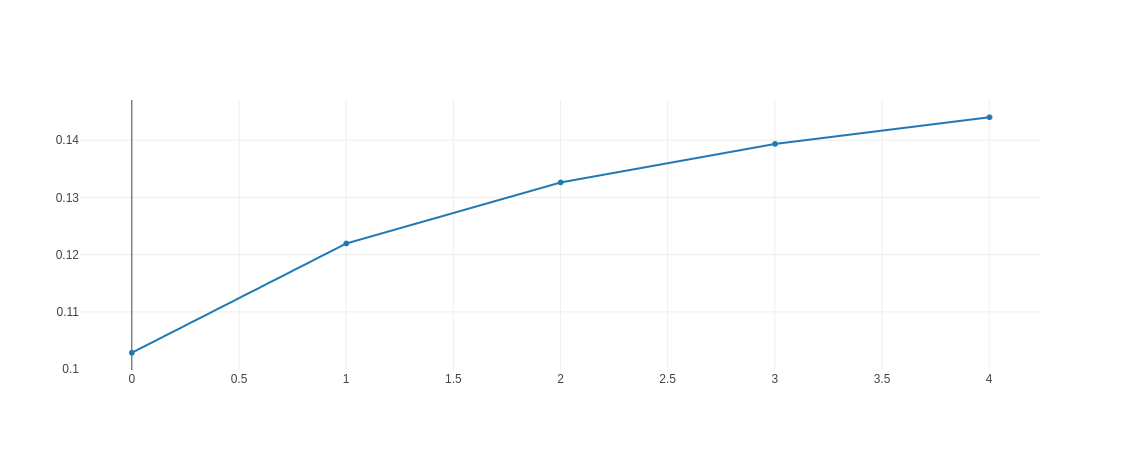

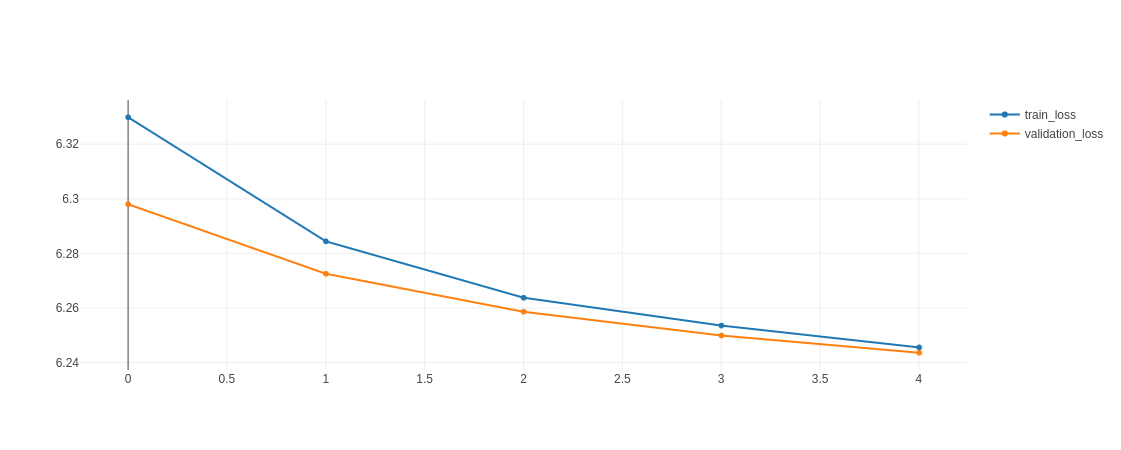

In [27]:
for measure in ['balanced_accuracy', 'train_and_validation_loss']:
    display(HTML(f"<center><h2><b>{measure.replace('_', ' ').title()} vs Epochs (Batch Size: {BATCH_SIZE})</b><h2></center>"))
    display(Image(filename=os.path.join(IMAGES_PATH, f'{measure}_CNN_epochs_batch-size-{BATCH_SIZE}.png')))

## Conclusiones

Al igual que en el Práctico 1, para este trabajo utilizamos de base los modelos, datasets, data loaders y funciones vistos en clase, pero realizando modificaciones necesarias para ajustarlas a este problema en particular, como mencionamos también en las secciones anteriores.

En primera instancia y en la primera entrega que realizamos, probamos utilizando dos valores de batch size, 128 y 512, y decidimos quedarnos con el este último valor; dado que observamos que mejoraban las tres curvas: el balanced accuracy aumenta, y el train/test loss disminuyen, lo cual indica que el modelo está "aprendiendo". No obstante, los valores del balanced accuracy se mostraban bastante bajos (< 1%), similares a los obtenidos en el Práctico 1. 

Por sugerencias de los profes probamos los siguientes cambios: 
1. Reemplazamos el embedding por uno entrenado en español.
2. Agregamos un paso de validación para quedarnos con el mejor modelo.
3. Cambiamos la función de activación de salida a Softmax dado que se trata de un problema de multiclasificación donde las clases son mutuamente excluyentes y esta función asegura que la suma de las probabilidades de todos los outputs sea 1.

En conjunción, todos los cambios incorporados nos permitieron una mejora sustancial enlas predicciones del modelo. Esto lo podemos observar en las curvas obtenidas: el balanced accuraccy mostró una tendencia creciente a medida que pasaron las epochs, con valores en torno a 12%. Si bien no es un valor alto, este es superior al obtenido con el modelo anterior (MLP). En relación a las curvas de error/pérdida vemos que tanto para el set de entrenamiento como el set de evaluación el error disminuye a medida que avanzan los epochs, lo cual indica que el modelo está "aprendiendo". No obstante, en ambos casos al tratarse de pocos epochs/ciclos no queda claro si las curvas podrían seguir descendiendo o si están prontas a estabilizarse, por lo que aumentando el número de epochs sería una forma de verificarlo. Esto último implica un mayor tiempo de entrenamiento, por lo cual no fue evaluado. 

Retomando la lógica planteada en el Práctico 1, otro factor que puede estar afectando el modelo es la calidad de las etiquetas, ya que sólo un bajo porcentaje de los registros tiene una etiqueta confiable (~8.5%). A esto se suma que el número de etiquetas a predecir es muy alto (632), por lo cual necesitaríamos un volumen importante de datos con buena calidad de etiquetas.

Por otro lado, dada la alta dimensionalidad del problema: usamos embeddings de texto y además hay una alta cantidad de outputs del modelo, uno por cada categoría/etiqueta a predecir, quizás se podría aplicar una arquitectura más compleja o variar diferentes parámetros del modelo como desarrollamos más adelante.

Como pasos a seguir, podríamos seguir probando con distintos hiperparámetros hasta obtener un modelo óptimo, e.g. haciendo un gridsearch o utilizando alguna librería como Optuna/Hyperopt. En línea con esto también se podría cambiar la arquitectura, aumentando la cantidad de capas convolucionales y/o filtros, como así también el tamaño de los mismos para probar si mejora el modelo, dado que probamos con una configuración simplificada en pos de mantener los tiempos de ejecución en rangos razonables (<3-4 horas). Esto debería estar acompañado de un chequeo/mejora de la calidad de los datos para ver mejoras significativas en los resultados.